# Cell Differentiation GO analysis

This analysis is to support https://github.com/geneontology/go-ontology/issues/24390

The goal here is to explore

 - consistent population of terms in "cell differentiation" patterns in the ontology
 - consistency of annotation of terms at different levels
 
This is to help us decide on how to best patternize differentiation. Ideally:

 1. We should consistently populate terms
 2. We should consistently annotate terms


__NOTE FOR ONTOLOGY EDITORS__ This is a Jupyter notebook. You do not need to understand any of the code here.
The notebook form makes the generation of the stats here reproducible and transparent. Any member of the GO
software team can help you run this for yourself, or tweak settings.

Scroll to the bottom for the main results.



## Initial setup

Here we import the necessary libraries:
    
 1. OAK, for ontology querying (labels and logical definitions)
 2. go_library, for annotation querying

In [1]:
from oaklib.selector import get_implementation_from_shorthand
from oaklib.datamodels.vocabulary import IS_A, PART_OF

In [2]:
oi = get_implementation_from_shorthand("sqlite:obo:go")

In [3]:
from go_library.datamodel.amigo_solr_api import AmigoSolrAPI
from go_library.amigo_solr.engine import create_handle
from go_library.datamodel.amigo_solr import Annotation, Bioentity

In [4]:
amigo = create_handle()

In [5]:
HUMAN = 'NCBITaxon:9606'

## IBA summaries

We write a convenience method to fetch IBA stats from AmiGO.

The intuition here is that terms annotated with IBA have been deemed to be trustworthy of propagation

In [6]:
def get_IBA_summary(term, taxon):
    """
    Returns: (total_anns, anns_to_IBA)
    """
    solr_params = {'facet': 'on',
                   'facet.mincount': 1,
                   'facet.field': ['evidence_type'],
                   'rows': 0}
    results = amigo.query_engine.search(Annotation,
                                                     solr_params=solr_params,
                                                     isa_partof_closure=term,
                                                     taxon=taxon)
    return results.num_found, results.facet_counts['evidence_type'].get('IBA', 0)


# test with an example term
get_IBA_summary("GO:0060911", HUMAN)
    

(14, 0)

## Convenience function to fetch genes

In [37]:
def get_genes(term, taxon):
    results = amigo.query_engine.search(Bioentity,
                                                     solr_params={'fl':'id', 'rows': 10000},
                                                     annotation_class_list=term,
                                                     taxon=taxon)
    return [e.id for e in results.items]

#get_genes("GO:0005634", HUMAN)

## Upset plots

These are superior to Venn diagrams in that they can show intersection between arbitrary numbers of sets.

We will use these to explore how often the same gene is populated to different terms

In [38]:
from upsetplot import from_contents
from upsetplot import UpSet

In [39]:
def compare_set(terms, taxon):
    #w = UpSetJSWidget[str]()
    results = {}
    for term in terms:
        label = oi.label(term)
        genes = get_genes(term, taxon)
        results[label] = genes
    df = from_contents(results)
    #return w.from_dict(results)
    #return df
    plt = UpSet(df, subset_size='count').plot()
    return plt


{'matrix': <AxesSubplot: >,
 'shading': <AxesSubplot: >,
 'totals': <AxesSubplot: >,
 'intersections': <AxesSubplot: ylabel='Intersection size'>}

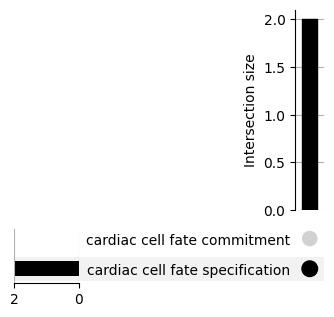

In [40]:
compare_set(["GO:0060911", "GO:0060912"], HUMAN)

## Cell Differentiation logical definitions

Here we fetch all cell differentiation descendants over is-a and part-of, and get all logical
definitions that reference a cell type

In [41]:
CELL_DIFFERENTIATION = "GO:0030154"
terms = list(oi.descendants(CELL_DIFFERENTIATION, predicates=[IS_A, PART_OF]))

In [42]:
ldefs = list(oi.logical_definitions(terms))

In [43]:
# check how many
len(ldefs)

589

In [44]:
# index by cell type
from collections import defaultdict

ldef_by_cell = defaultdict(list)
for ldef in ldefs:
    if len(ldef.restrictions) != 1:
        continue
    cell = ldef.restrictions[0].fillerId
    if not cell.startswith("CL:") and not cell.startswith("PO:") and not cell.startswith("FAO:"):
        continue
    ldef_by_cell[cell].append(ldef)
print(len(ldef_by_cell))

262


In [45]:
# filter to only cell types that have >1 associated logical definition
ldef_by_cell = {k: v for k, v in ldef_by_cell.items() if len(v) > 1}

## Summarize Logical Definitions indexed by Cell Type

 - **TODO** make this prettier
 - **TODO** filter to get only differentiation DPs (diff, fate commitment, specification, maturation, ...)

In [46]:
import pandas as pd

In [47]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 20)

In [48]:
items = {}
for cell, cell_ldefs in ldef_by_cell.items():
    items[cell] = {}
    items[cell]['id'] = cell
    items[cell]['name'] = oi.label(cell)
    genus_terms = [ldef.genusIds for ldef in cell_ldefs]
    for g in genus_terms:
        items[cell][oi.label(g[0])] = ldef.definedClassId
df = pd.DataFrame(items.values())
df

,id,name,cell migration,cell recognition,developmental maturation,cell differentiation,cell fate commitment,anatomical structure morphogenesis,developmental process,cell development,...,biological_process,anatomical structure development,cell fate specification,chemotaxis,cell activation,cell division,asymmetric cell division,symmetric stem cell division,establishment of cell polarity,maintenance of cell polarity
0,CL:0000540,neuron,GO:2001266,GO:2001266,GO:2001266,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CL:2000020,inner cell mass cell,NaN,NaN,NaN,GO:2001266,GO:2001266,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CL:1000274,trophectodermal cell,NaN,NaN,NaN,GO:2001266,GO:2001266,GO:2001266,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CL:0000814,mature NK T cell,NaN,NaN,NaN,GO:2001266,GO:2001266,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CL:0000115,endothelial cell,NaN,NaN,NaN,GO:2001266,NaN,GO:2001266,GO:2001266,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CL:0000819,B-1 B cell,NaN,NaN,NaN,GO:2001266,GO:2001266,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,CL:0000062,osteoblast,NaN,NaN,NaN,NaN,GO:2001266,NaN,GO:2001266,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,CL:0000138,chondrocyte,NaN,NaN,NaN,GO:2001266,NaN,GO:2001266,GO:2001266,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,CL:0000066,epithelial cell,NaN,NaN,GO:2001266,GO:2001266,NaN,GO:2001266,GO:2001266,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,CL:0000075,columnar/cuboidal epithelial cell,NaN,NaN,GO:2001266,GO:2001266,NaN,NaN,GO:2001266,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
items = []
for cell, cell_ldefs in ldef_by_cell.items():
    genus_terms = [ldef.genusIds for ldef in cell_ldefs]
    items.append({'id':cell, 'name':oi.label(cell), 'genus_terms': "; ".join([oi.label(g[0]) for g in genus_terms])})
    print(f"  {cell} {oi.label(cell)} : {len(cell_ldefs)} -- {[oi.label(g[0]) for g in genus_terms]}")



  CL:0000540 neuron : 3 -- ['cell migration', 'cell recognition', 'developmental maturation']
  CL:2000020 inner cell mass cell : 2 -- ['cell differentiation', 'cell fate commitment']
  CL:1000274 trophectodermal cell : 3 -- ['cell differentiation', 'cell fate commitment', 'anatomical structure morphogenesis']
  CL:0000814 mature NK T cell : 2 -- ['cell differentiation', 'cell fate commitment']
  CL:0000115 endothelial cell : 3 -- ['developmental process', 'anatomical structure morphogenesis', 'cell differentiation']
  CL:0000819 B-1 B cell : 2 -- ['cell differentiation', 'cell fate commitment']
  CL:0000062 osteoblast : 2 -- ['cell fate commitment', 'developmental process']
  CL:0000138 chondrocyte : 3 -- ['cell differentiation', 'developmental process', 'anatomical structure morphogenesis']
  CL:0000066 epithelial cell : 4 -- ['developmental process', 'developmental maturation', 'anatomical structure morphogenesis', 'cell differentiation']
  CL:0000075 columnar/cuboidal epithelial ce

In [50]:
pd.set_option('max_colwidth', 120)
pd.DataFrame(items)

,id,name,genus_terms
0,CL:0000540,neuron,cell migration; cell recognition; developmental maturation
1,CL:2000020,inner cell mass cell,cell differentiation; cell fate commitment
2,CL:1000274,trophectodermal cell,cell differentiation; cell fate commitment; anatomical structure morphogenesis
3,CL:0000814,mature NK T cell,cell differentiation; cell fate commitment
4,CL:0000115,endothelial cell,developmental process; anatomical structure morphogenesis; cell differentiation
5,CL:0000819,B-1 B cell,cell differentiation; cell fate commitment
6,CL:0000062,osteoblast,cell fate commitment; developmental process
7,CL:0000138,chondrocyte,cell differentiation; developmental process; anatomical structure morphogenesis
8,CL:0000066,epithelial cell,developmental process; developmental maturation; anatomical structure morphogenesis; cell differentiation
9,CL:0000075,columnar/cuboidal epithelial cell,cell differentiation; developmental process; developmental maturation


## Cell Type Summarization function

This creates a function that will

 - summarize all GO terms with logical defs that reference that cell
 - give basic annotation stats
 - draw an upset plot showing how genes are distributed across those terms
 
 TODO: draw a visualization of how the terms relate

In [51]:
def cell_summary(cell, taxon):
    cell_label = oi.label(cell)
    print(f"SUMMARY FOR {cell} {cell_label}")
    go_terms = [ldef.definedClassId for ldef in ldef_by_cell[cell]]
    for term in go_terms:
        anns, ibas = get_IBA_summary(term, taxon)
        print(f" * {term} {oi.label(term)} IBAs: {ibas} Anns: {anns}")
    return compare_set(go_terms, taxon)
    

## EXAMPLE: Stem cell (human)

SUMMARY FOR CL:0000034 stem cell
 * GO:0048863 stem cell differentiation IBAs: 27 Anns: 212
 * GO:0048864 stem cell development IBAs: 27 Anns: 101
 * GO:0048865 stem cell fate commitment IBAs: 0 Anns: 10
 * GO:0048866 stem cell fate specification IBAs: 0 Anns: 6
 * GO:0048867 stem cell fate determination IBAs: 0 Anns: 0


{'matrix': <AxesSubplot: >,
 'shading': <AxesSubplot: >,
 'totals': <AxesSubplot: >,
 'intersections': <AxesSubplot: ylabel='Intersection size'>}

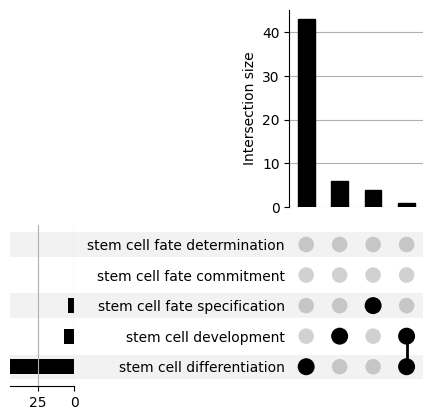

In [52]:
cell_summary("CL:0000034", HUMAN)

SUMMARY FOR CL:0000034 stem cell
 * GO:0048863 stem cell differentiation IBAs: 27 Anns: 339
 * GO:0048864 stem cell development IBAs: 27 Anns: 166
 * GO:0048865 stem cell fate commitment IBAs: 0 Anns: 10
 * GO:0048866 stem cell fate specification IBAs: 0 Anns: 5
 * GO:0048867 stem cell fate determination IBAs: 0 Anns: 0


{'matrix': <AxesSubplot: >,
 'shading': <AxesSubplot: >,
 'totals': <AxesSubplot: >,
 'intersections': <AxesSubplot: ylabel='Intersection size'>}

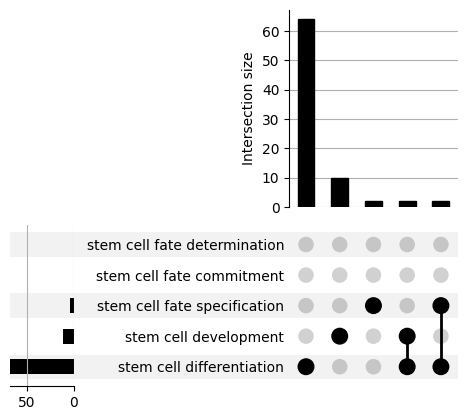

In [53]:
MOUSE = "NCBITaxon:10090"
cell_summary("CL:0000034", MOUSE)

In [54]:
DMEL = "NCBITaxon:7227"

SUMMARY FOR CL:0000210 photoreceptor cell
 * GO:0042461 photoreceptor cell development IBAs: 4 Anns: 169
 * GO:0043703 photoreceptor cell fate determination IBAs: 0 Anns: 7
 * GO:0043704 photoreceptor cell fate specification IBAs: 0 Anns: 23
 * GO:0046530 photoreceptor cell differentiation IBAs: 4 Anns: 454
 * GO:0046552 photoreceptor cell fate commitment IBAs: 0 Anns: 203


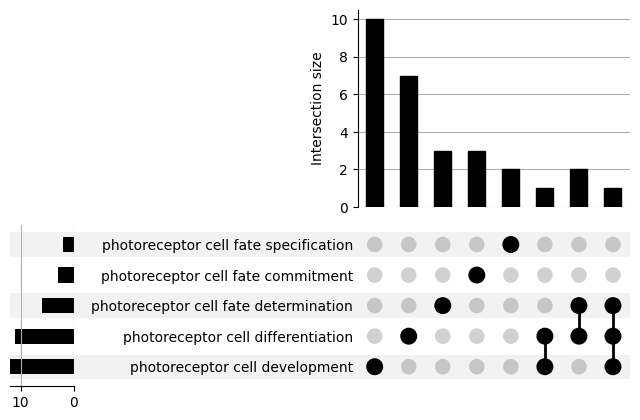

In [55]:
w = cell_summary("CL:0000210", DMEL)